# Decision Boundary Example #

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2025-02-04 14:43:00.962419: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-04 14:43:01.007361: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-04 14:43:01.007378: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-04 14:43:01.007383: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-04 14:43:01.015050: I tensorflow/core/platform/cpu_feature_g

Num GPUs Available:  1


2025-02-04 14:43:03.541219: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-04 14:43:03.573862: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-04 14:43:03.574101: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

We are going to build a model to create a "decision boundary" or "discrimination boundary". We will use a fictional dataset. To start, we will load the modules required to accomplish this task. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In this case the three elements of the machine learning model are
- Experience/Data/Input: a collection of labeled data points representing two measured parameters of flowers:  petal width and stem height. 
- Task: train the model to classify a flower either as an "iris" or a "rose" 
- Performance/Cost function: Minimize the mean squared error of flowers that are incorrectly classified

Next, we define some program parameters. These can be modified which will change the results. For clarity, the `starting_weights` variable takes one of three values which will come into play in the next segment.

In [3]:
epochs = 500
batch_size = 4
starting_weights = 2 # 0: bad -- 1: good == 2: random

This next section will choose the learning rate and initial weights based on your choice for `starting_weights`.

In [4]:
if starting_weights == 0:
    learning_rate = 2e-2
    weights = np.array([[-1.6,-0.15,1.33]]).T
elif starting_weights == 1:
    learning_rate = 1e-3
    weights = np.array([[1.85,-2.25,-0.35]]).T
elif starting_weights == 2:
    learning_rate = 1e-3
    weights = np.random.normal(loc=0,scale=1,size=[3,1])
else:
    raise ValueError('Invalid argument for starting_weights. Must be 0, 1, or 2. You chose',starting_weights)

The following section defines all required functions to make the program run efficiently. They also allow for the training section of the code to be easier to comprehend.

In [5]:
def sigmoid(x):
    # returns sigmoid output for a given value `x`
    return 1/(1+np.exp(-x))
def sigmoid_deriv(x):
    # returns derivative sigmoid output for a given value `x` (used for backpropagation)
    return sigmoid(x)*(1-sigmoid(x))
def loss_mse(y,yhat):
    # computes the mean squared error between the truth `y` and the prediction `yhat`
    return np.power(y-yhat,2)
def loss_deriv(y,yhat):
    # computes the derivative of the mean squared error (used for backpropagation)
    return -2 * (y-yhat)
def forward_pass(x,weights):
    # takes the x- and y-coordinates and runs the model to get a prediction
    inputs = np.array([[x[0],x[1],1.]])
    return sigmoid((inputs@weights)[0])
def backward_pass(x,weights):
    # computing the output of the sigmoid derivative through the model
    inputs = np.array([[x[0],x[1],1.]])
    return sigmoid_deriv((inputs@weights)[0]) * inputs.T
def predict(x,weights):
    # makes prediction (either blue or red) based on the x,y coordinates
    y_pred = forward_pass(x,weights)
    out = int(np.round(y_pred))
    print(["Blue","Red"][out])
def plot_line(ax,weights):
    # first, traverse up left edge of plot and find where model predicts blue
    y_test = np.linspace(0,4,100)
    cL = 0
    while forward_pass(np.array([0.9,y_test[cL]]),weights) > 0.5 and cL < len(y_test)-1:
        cL += 1
    # next, traverse up right edge of plot and find where model predicts blue
    cR = 0
    while forward_pass(np.array([3.1,y_test[cR]]),weights) > 0.5 and cR < len(y_test)-1:
        cR += 1
    # plot line that goes through the boundary discrimination points
    line1, = ax.plot([0.9,3.1],[y_test[cL],y_test[cR]],color='black')
    return line1 # return line object, so we can delete it before plotting another line
def shuffle(x,y):
    ind = np.linspace(0,len(y)-1,len(y),dtype='int')
    np.random.shuffle(ind)
    return x[ind,:], y[ind]

Next, we load the data file. This file contains 100 samples. Each sample is of the form (x1_coordinate, x2_coordinate, value) where value is either 0 or 1 (blue or red).

In [6]:
data = pd.read_csv('https://raw.githubusercontent.com/HelioAnalytics/EPSCOR_Hackweek/main/Course%20Materials/flowers.csv',header=None,index_col=None).values
x = data[:,0:2]
y = data[:,-1]

Plot data to visualize dataset. The black line is the discrimination boundary with the initial weights

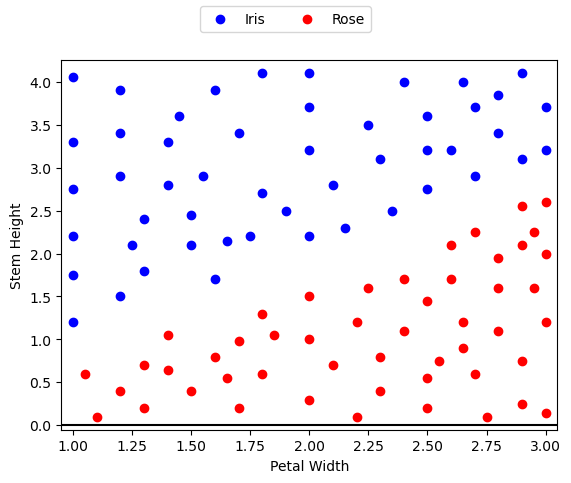

In [7]:
fig,ax=plt.subplots()
ax.scatter(data[data[:,2]==0,0],data[data[:,2]==0,1],color='blue',label='Iris')
ax.scatter(data[data[:,2]==1,0],data[data[:,2]==1,1],color='red',label='Rose')
ax.set_xlabel('Petal Width')
ax.set_ylabel('Stem Height')
ax.set_xlim([0.95,3.05])
ax.set_ylim([-0.05,4.25])
fig.legend(ncol=2,loc='upper center')
plot_line(ax,weights)

Here is the main training loop. We have commented out the line to shuffle the data but that can be un-commented. Read the comments throughout the loop to understand what is going on.

In [8]:
loss = []
for epoch in range(epochs):
    # x,y = shuffle(x,y) # shuffle order of data (uncomment to implement shuffling)
    # initialize lists
    loss_epoch = []
    batch = []
    for i in range(x.shape[0]):
        y_pred = forward_pass(x[i,:],weights) # do forward pass to get prediction
        loss_epoch.append(loss_mse(y[i],y_pred)) # compute loss and add it to list
        lossD = loss_deriv(y[i],y_pred) # compute derivative of loss (2*(y-ypred))
        # Compute gradient for this sample, it will be averaged across batch
        batch.append(learning_rate * lossD * backward_pass(x[i,:],weights))
        if (i+1) % batch_size == 0:
            weights -= np.mean(batch,0) # adjust weights based on average loss
            batch = [] # re-initialize list
    loss.append(np.mean(loss_epoch))


Now let's plot the data with the final discrimination boundary (black line).

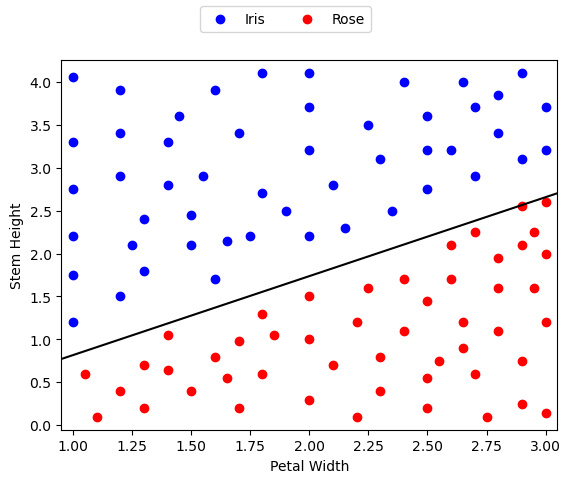

In [9]:
fig,ax=plt.subplots()
ax.scatter(data[data[:,2]==0,0],data[data[:,2]==0,1],color='blue',label='Iris')
ax.scatter(data[data[:,2]==1,0],data[data[:,2]==1,1],color='red',label='Rose')
ax.set_xlabel('Petal Width')
ax.set_ylabel('Stem Height')
ax.set_xlim([0.95,3.05])
ax.set_ylim([-0.05,4.25])
fig.legend(ncol=2,loc='upper center')
line1 = plot_line(ax,weights)

Finally, let's plot the loss curve. This will show the average mean squared error after every epoch. If the training is set up correctly, the loss will decrease continuously through training.

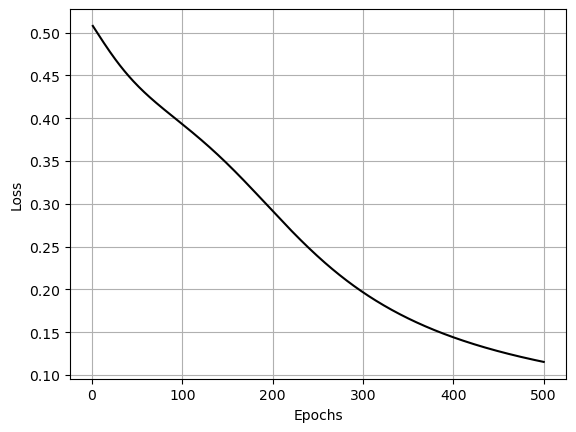

In [10]:
fig,ax=plt.subplots()
plt.plot(np.linspace(1,500,500),loss,color='black')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()

# Exploration #

- What happens if the separation between the datasets isn't so clear?  
- How would you approach this problem if the boundary wasn't a straight line?
- Do the hyperparameters for batch size, number of epochs, and learning rates have more impact on the speed or the accuracy of the model? 